<h1 align="center">Dimensionality Reduction</h1> 
<h3 align="center">BSAI course, Autumn, 2025</h3> 

In this tutorial we will go over some basic concepts and implementations of PCA (Principal Component Analysis) as linear dimensionality reduction technique. We will also explore t-SNE (t-distributed Stochastic Neighbor Embedding) as a non-linear dimensionality reduction technique.

Reference:

- [Neuromatch Dimensionality Reduction tutorial](https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/student/W1D4_Intro.html)


**Environment setup**:

You can use the enviroment you created for week2 -- allensdk.

Or you may just need to install the following packages if you don't have them yet:
```bash
pip install numpy scikit-learn matplotlib seaborn
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets

# Geometric View of Data

In [2]:
# Plotting Functions
def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  plot of their joint activity. The title indicates the sample correlation
  calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  plt.title(f'Sample var 1: {np.var(X[:, 0]):.1f}')
  ax1.set_xticklabels([])
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number')
  plt.ylabel('Neuron 2')
  plt.title(f'Sample var 2: {np.var(X[:, 1]):.1f}')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title(f'Sample corr: {np.corrcoef(X[:, 0], X[:, 1])[0, 1]:.1f}')
  plt.show()


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases.
  Similar to plot_data but with colors corresponding to projections onto
  basis 1 (red) and basis 2 (blue). The title indicates the sample correlation
  calculated from the data.

  Note that samples are re-sorted in ascending order for the first
  random variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """
  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.xlabel
  plt.ylabel('Projection \n basis vector 1')
  plt.title(f'Sample var 1: {np.var(Y[:, 0]):.1f}')
  ax1.set_xticklabels([])
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  plt.title(f'Sample var 2: {np.var(Y[:, 1]):.1f}')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title(f'Sample corr: {np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]:.1f}')
  plt.show()

def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])
  plt.show()


## 1. Generate correlated multivariate data

To gain intuition, we will first use a simple model to generate multivariate data. Specifically, we will draw random samples from a *bivariate normal distribution*. This is an extension of the one-dimensional normal distribution to two dimensions, in which each $x_i$ is marginally normal with mean $\mu_i$ and variance $\sigma_i^2$:

\begin{equation}
x_i \sim \mathcal{N}(\mu_i,\sigma_i^2).
\end{equation}

Additionally, the joint distribution for $x_1$ and $x_2$ has a specified correlation coefficient $\rho$. Recall that the correlation coefficient is a normalized version of the covariance, and ranges between -1 and +1:

\begin{equation}
\rho = \frac{\text{cov}(x_1, x_2)}{\sqrt{\sigma_1^2 \sigma_2^2}}.
\end{equation}

For simplicity, we will assume that the mean of each variable has already been subtracted, so that $\mu_i=0$ for both $i=1$ and $i=2$. The remaining parameters can be summarized in the covariance matrix, which for two dimensions has the following form:

\begin{equation}
{\bf \Sigma} =
\begin{pmatrix}
 \text{var}(x_1) & \text{cov}(x_1,x_2) \\
 \text{cov}(x_1,x_2) &\text{var}(x_2)
\end{pmatrix}.
\end{equation}

In general, $\bf \Sigma$ is a symmetric matrix with the variances $\text{var}(x_i) = \sigma_i^2$ on the diagonal, and the covariances on the off-diagonal. Later, we will see that the covariance matrix plays a key role in PCA.


## Coding Exercise 1: Draw samples from a distribution

We have provided code to draw random samples from a zero-mean bivariate normal distribution with a specified covariance matrix (`get_data`). Throughout this tutorial, we'll imagine these samples represent the activity (firing rates) of two recorded neurons on different trials. Fill in the function below to calculate the covariance matrix given the desired variances and correlation coefficient. The covariance can be found by rearranging the equation above:

\begin{equation}
\text{cov}(x_1,x_2) = \rho \sqrt{\sigma_1^2 \sigma_2^2}.
\end{equation}

In [3]:
# @markdown Execute this cell to get helper function `get_data`

def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian.

  Note that samples are sorted in ascending order for the first random variable

  Args:
    cov_matrix (numpy array of floats): desired covariance matrix

  Returns:
    (numpy array of floats) : samples from the bivariate Gaussian, with each
                              column corresponding to a different random
                              variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]

  return X


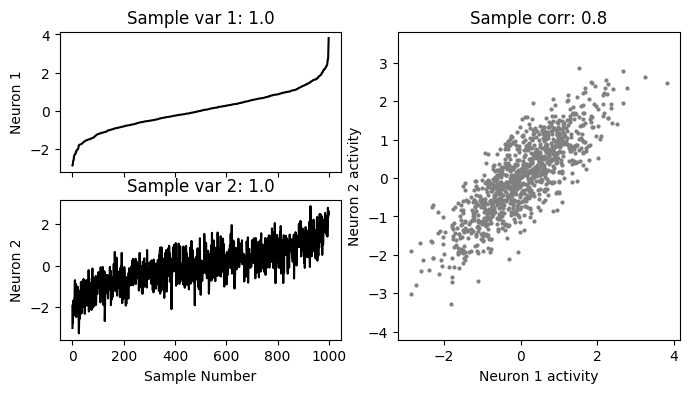

In [ ]:
def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and correlation
  coefficient.

  Args:
    var_1 (scalar)          : variance of the first random variable
    var_2 (scalar)          : variance of the second random variable
    corr_coef (scalar)      : correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """

  # Calculate the covariance from the variances and correlation
  cov = ...
  
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])

  return cov_matrix


# Set parameters
np.random.seed(2020)  # set random seed
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

# Compute covariance matrix
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)

# Generate data with this covariance matrix
X = get_data(cov_matrix)

# Visualize
plot_data(X)

## Interactive Demo 1: Correlation effect on data

We'll use the function you just completed but now we can change the correlation coefficient via slider. You should get a feel for how changing the correlation coefficient affects the geometry of the simulated data.

1.   What effect do negative correlation coefficient values have?
2.   What correlation coefficient results in a circular data cloud?


Note that we sort the samples according to neuron 1's firing rate, meaning the plot of neuron 1 firing rate over sample number looks clean and pretty unchanging when compared to neuron 2.


In [ ]:
# @markdown Execute this cell to enable widget

def _calculate_cov_matrix(var_1, var_2, corr_coef):

  # Calculate the covariance from the variances and correlation
  cov = corr_coef * np.sqrt(var_1 * var_2)

  cov_matrix = np.array([[var_1, cov], [cov, var_2]])

  return cov_matrix


@widgets.interact(corr_coef = widgets.FloatSlider(value=.2, min=-1, max=1, step=0.1))
def visualize_correlated_data(corr_coef=0):
  variance_1 = 1
  variance_2 = 1

  # Compute covariance matrix
  cov_matrix = _calculate_cov_matrix(variance_1, variance_2, corr_coef)

  # Generate data with this covariance matrix
  X = get_data(cov_matrix)

  # Visualize
  plot_data(X)

interactive(children=(FloatSlider(value=0.2, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…

## 2. Define a new orthonormal basis


Next, we will define a new orthonormal basis of vectors ${\bf u} = [u_1,u_2]$ and ${\bf w} = [w_1,w_2]$. As we learned in the video, two vectors are orthonormal if:

1. They are orthogonal (i.e., their dot product is zero):

\begin{equation}
{\bf u\cdot w} = u_1 w_1 + u_2 w_2 = 0
\end{equation}

2. They have unit length:

\begin{equation}
||{\bf u}|| = ||{\bf w} || = 1
\end{equation}

In two dimensions, it is easy to make an arbitrary orthonormal basis. All we need is a random vector ${\bf u}$, which we have normalized. If we now define the second basis vector to be ${\bf w} = [-u_2,u_1]$, we can check that both conditions are satisfied:

\begin{equation}
{\bf u\cdot w} = - u_1 u_2 + u_2 u_1 = 0
\end{equation}

and

\begin{equation}
{|| {\bf w} ||} = \sqrt{(-u_2)^2 + u_1^2} = \sqrt{u_1^2 + u_2^2} = 1,
\end{equation}

where we used the fact that ${\bf u}$ is normalized. So, with an arbitrary input vector, we can define an orthonormal basis, which we will write in matrix by stacking the basis vectors horizontally:

\begin{equation}
{{\bf W} } =
\begin{pmatrix}
 u_1 & w_1 \\
 u_2 & w_2
\end{pmatrix}.
\end{equation}

## Coding Exercise 2: Find an orthonormal basis

In this exercise you will fill in the function below to define an orthonormal basis, given a single arbitrary 2-dimensional vector as an input.

**Steps**
* Modify the function `define_orthonormal_basis` to first normalize the first basis vector $\bf u$.
* Then complete the function by finding a basis vector $\bf w$ that is orthogonal to $\bf u$.
* Test the function using initial basis vector ${\bf u} = [3,1]$. Plot the resulting basis vectors on top of the data scatter plot using the function `plot_basis_vectors`. (For the data, use  $\sigma_1^2 =1$, $\sigma_2^2 =1$, and $\rho = .8$).

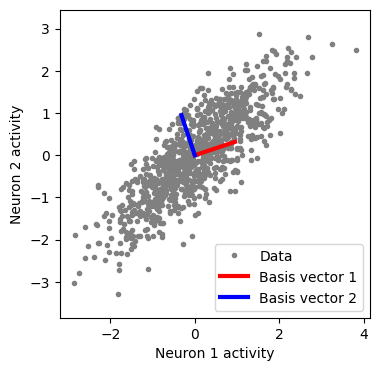

In [ ]:
def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2-dimensional vector used for new
                                basis

  Returns:
    (numpy array of floats)   : new orthonormal basis
                                columns correspond to basis vectors
  """

  # Normalize vector u
  u = ...

  # Calculate vector w that is orthogonal to u
  w = ...

  # Put in matrix form
  W = np.column_stack([u, w])

  return W


# Set up parameters
np.random.seed(2020)  # set random seed
variance_1 = 1
variance_2 = 1
corr_coef = 0.8
u = np.array([3, 1])

# Compute covariance matrix
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)

# Generate data
X = get_data(cov_matrix)

# Get orthonomal basis
W = define_orthonormal_basis(u)

# Visualize
plot_basis_vectors(X, W)

---
## Section 3: Project data onto new basis

Finally, we will express our data in the new basis that we have just found. Since $\bf W$ is orthonormal, we can project the data into our new basis using simple matrix multiplication :

\begin{equation}
{\bf Y = X W}.
\end{equation}

We will explore the geometry of the transformed data $\bf Y$ as we vary the choice of basis.

## Coding Exercise 3: Change to orthonormal basis
In this exercise you will fill in the function below to change data to an orthonormal basis.

**Steps**
* Complete the function `change_of_basis` to project the data onto the new basis.
* Plot the projected data using the function `plot_data_new_basis`.
* What happens to the correlation coefficient in the new basis? Does it increase or decrease?
* What happens to variance?



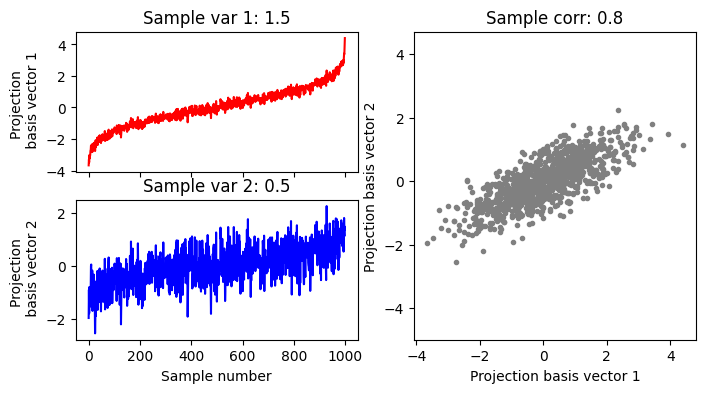

In [7]:
def change_of_basis(X, W):
  """
  Projects data onto new basis W.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)    : Data matrix expressed in new basis
  """

  # Project data onto new basis described by W
  # Y = ...
  Y = X @ W

  return Y


# Project data to new basis
Y = change_of_basis(X, W)

# Visualize

plot_data_new_basis(Y)

## Interactive Demo 3: Play with the basis vectors
To see what happens to the correlation as we change the basis vectors, run the cell below. The parameter $\theta$ controls the angle of $\bf u$ in degrees. Use the slider to rotate the basis vectors.



1.   What happens to the projected data as you rotate the basis?
2.   How does the correlation coefficient change? How does the variance of the projection onto each basis vector change?
3.   Are you able to find a basis in which the projected data is **uncorrelated**?

In [31]:
def refresh(theta=0):
  u = np.array([1, np.tan(theta * np.pi / 180)])
  W = define_orthonormal_basis(u)
  Y = change_of_basis(X, W)
  plot_basis_vectors(X, W)
  plot_data_new_basis(Y)


_ = widgets.interact(refresh, theta=(0, 90, 5))

interactive(children=(IntSlider(value=0, description='theta', max=90, step=5), Output()), _dom_classes=('widge…

# Principal Component Analysis (PCA)

In [9]:
# some helper functions for later use
def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors


def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y

---
## Section 4: Calculate the eigenvectors of the the sample covariance matrix

As we saw in the lecture, PCA represents data in a new orthonormal basis defined by the eigenvectors of the covariance matrix. Remember that in the previous tutorial, we generated bivariate normal data with a specified covariance matrix $\bf \Sigma$ , whose $(i,j)$ th element is:

\begin{equation}
\Sigma_{ij} = \mathbb{E}[ x_i x_j ] - \mathbb{E}[ x_i] \mathbb{E}[ x_j ] .
\end{equation}

However, in real life we don't have access to this ground-truth covariance
matrix. To get around this, we can use the sample covariance matrix, $\bf\hat\Sigma$, which is calculated directly from the data. The $(i,j)$th element of the sample covariance matrix is:

\begin{equation}
\hat \Sigma_{ij} =  \frac{1}{N_\text{samples}}{\bf x}_i^\top {\bf x}_j - \bar {\bf x}_i \bar{\bf x}_j ,
\end{equation}

where ${\bf x}_i = [ x_i(1), x_i(2), \dots,x_i(N_\text{samples})]^\top$ is a column vector representing all measurements of neuron $i$, and  $\bar {\bf x}_i$ is the mean of neuron $i$ across samples:

\begin{equation}
\bar {\bf x}_i = \frac{1}{N_\text{samples}} \sum_{k=1}^{N_\text{samples}} x_i(k).
\end{equation}

If we assume that the data has already been mean-subtracted, then we can write the sample covariance matrix in a much simpler matrix form:

\begin{equation}
{\bf \hat \Sigma} = \frac{1}{N_\text{samples}} {\bf X}^\top {\bf X}.
\end{equation}

where $\bf X$ is the full data matrix (each column of $\bf X$ is a different $\bf x_i$).

## Coding Exercise 4.1: Calculate the covariance matrix

Before calculating the eigenvectors, you must first calculate the sample covariance matrix.

**Steps**
* Complete the function `get_sample_cov_matrix` by first subtracting the sample mean of the data, then calculate $\bf \hat \Sigma$ using the equation above.
* Use `get_data` to generate bivariate normal data, and calculate the sample covariance matrix with your finished `get_sample_cov_matrix`. Compare this estimate to the true covariate matrix using `calculate_cov_matrix`. You've seen both `get_data` and `calculate_cov_matrix` in Tutorial 1.


In [ ]:
def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = ...

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)

  return cov_matrix


# Set parameters
np.random.seed(2020)  # set random seed
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

# Calculate covariance matrix
# cov_matrix = ...
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
print(cov_matrix)

# Generate data with that covariance matrix
X = get_data(cov_matrix)

# Get sample covariance matrix
sample_cov_matrix = get_sample_cov_matrix(X)
print(sample_cov_matrix)

[[1.  0.8]
 [0.8 1. ]]
[[0.99315313 0.82347589]
 [0.82347589 1.01281397]]


We get a sample covariance matrix that doesn't look too far off from the true covariance matrix, so that's a good sign!

## Coding Exercise 4.2: Eigenvectors of the covariance matrix

Next you will calculate the eigenvectors of the covariance matrix. Plot them along with the data to check that they align with the geometry of the data.

**Steps:**
* Calculate the eigenvalues and eigenvectors of the sample covariance matrix. (**Hint:** use `np.linalg.eigh`, which finds the eigenvalues of a symmetric matrix).
* Use the provided code to sort the eigenvalues in descending order.
* Plot the eigenvectors on a scatter plot of the data, using the function `plot_basis_vectors`.

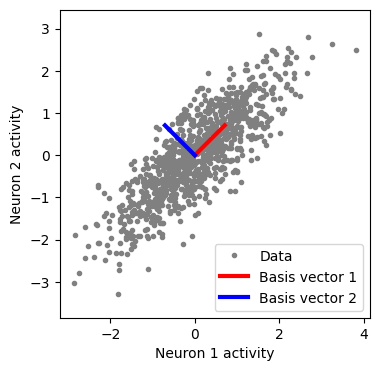

In [ ]:
# Calculate the eigenvalues and eigenvectors
evals, evectors = ...

# Sort the eigenvalues in descending order
evals, evectors = ...

# Visualize
plot_basis_vectors(X, evectors)

---
## Section 5: Perform PCA by projecting data onto the eigenvectors



To perform PCA, we will project the data onto the eigenvectors of the covariance matrix, i.e.,:

\begin{equation}
\bf S = X W
\end{equation}

where $\bf S$ is an $N_\text{samples} \times N$ matrix representing the projected data (also called *scores*), and $\bf W$ is an $N\times N$ orthogonal matrix, each of whose columns represents the eigenvectors of the covariance matrix (also called *weights* or *loadings*).

## Coding Exercise 5: PCA implementation

You will now perform PCA on the data using the intuition and functions you have developed so far. Fill in the function below to carry out the steps to perform PCA by projecting the data onto the eigenvectors of its covariance matrix.

**Steps:**
* First subtract the mean and calculate the sample covariance matrix.
* Then find the eigenvalues and eigenvectors and sort them in descending order.
* Finally project the mean-centered data onto the eigenvectors.

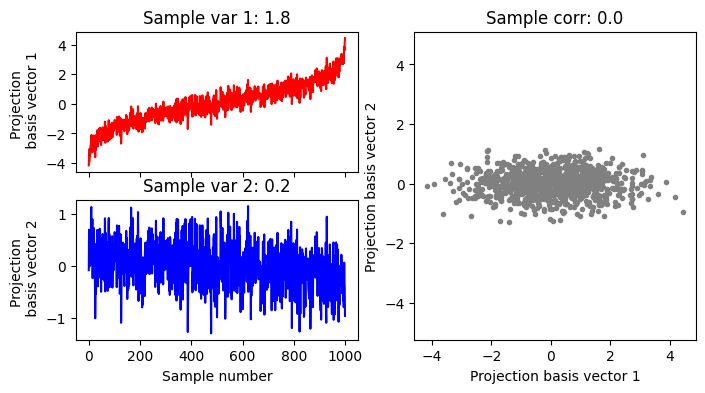

In [ ]:
# to_remove solution
def pca(X):
  """
  Performs PCA on multivariate data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors

  """

  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)

  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals


# Perform PCA on the data matrix X
score, evectors, evals = ...

# Plot the data projected into the new basis
plot_data_new_basis(score)

   Finally, we will examine the eigenvalues of the covariance matrix. Remember that each eigenvalue describes the variance of the data projected onto its corresponding eigenvector. This is an important concept because it allows us to rank the PCA basis vectors based on how much variance each one can capture. First run the code below to plot the eigenvalues (sometimes called the "scree plot"). Which eigenvalue is larger?

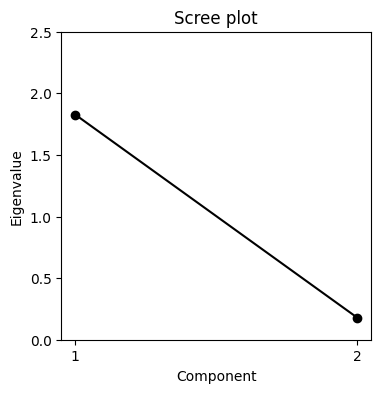

In [13]:
plot_eigenvalues(evals)

## Interactive Demo 4: Exploration of the correlation coefficient

Run the following cell and use the slider to change the correlation coefficient in the data. You should see the scree plot and the plot of basis vectors updated.

1.  What happens to the eigenvalues as you change the correlation coefficient?
2.  Can you find a value for which both eigenvalues are equal?
3.  Can you find a value for which only one eigenvalue is nonzero?

In [14]:

def refresh(corr_coef=.8):
  cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
  X = get_data(cov_matrix)
  score, evectors, evals = pca(X)
  plot_eigenvalues(evals)
  plot_basis_vectors(X, evectors)


_ = widgets.interact(refresh, corr_coef=(-1, 1, .1))

interactive(children=(FloatSlider(value=0.8, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…

# Dimensionality Reduction & Reconstruction

In [40]:
# Plotting Functions

def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()


def plot_MNIST_reconstruction(X, X_reconstructed, keep_dims):
  """
  Plots 9 images in the MNIST dataset side-by-side with the reconstructed
  images.

  Args:
    X (numpy array of floats)               : Data matrix each column
                                              corresponds to a different
                                              random variable
    X_reconstructed (numpy array of floats) : Data matrix each column
                                              corresponds to a different
                                              random variable
    keep_dims (int)                         : Dimensions to keep

  Returns:
    Nothing.
  """

  plt.figure()
  ax = plt.subplot(121)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.title('Data')
  plt.clim([0, 250])
  ax = plt.subplot(122)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(np.real(X_reconstructed[k, :]), (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.clim([0, 250])
  plt.title(f'Reconstructed K: {keep_dims}')
  plt.tight_layout()
  plt.show()


def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(5):
    for k2 in range(5):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((5 * 28, 0))
  plt.ylim((5 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 250])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_MNIST_weights(weights):
  """
  Visualize PCA basis vector weights for MNIST. Red = positive weights,
  blue = negative weights, white = zero weight.

  Args:
     weights (numpy array of floats) : PCA basis vector

  Returns:
     Nothing.
  """

  fig, ax = plt.subplots()
  plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap='seismic')
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_eigenvalues(evals, xlimit=False):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues
     (boolean) : enable plt.show()
  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if xlimit:
    plt.xlim([0, 100])  # limit x-axis up to 100 for zooming
  plt.show()

In [16]:
# @ Helper Functions

def add_noise(X, frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.

  Args:
     X (numpy array of floats)  : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels

  Returns:
     (numpy array of floats)    : Data matrix + noise

  """

  X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
  X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

  return X_noisy


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals

---
## Section 6: Perform PCA on MNIST

The MNIST dataset consists of 70,000 images of individual handwritten digits. Each image is a 28x28 pixel grayscale image. For convenience, each 28x28 pixel image is often unravelled into a single 784 (=28x28) element vector, so that the whole dataset is represented as a 70,000 x 784 matrix. Each row represents a different image, and each column represents a different pixel.

Enter the following cell to load the MNIST dataset and plot the first nine images. It may take a few minutes to load.

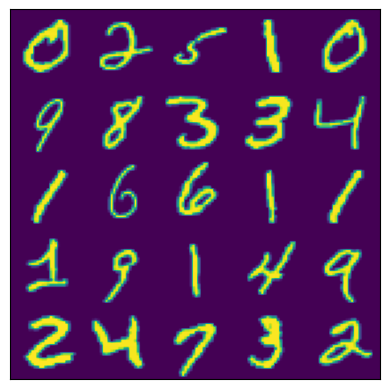

In [41]:
from sklearn.datasets import fetch_openml

# GET mnist data
mnist = fetch_openml(name='mnist_784', as_frame=False, parser='auto')
X = mnist.data

# Visualize
plot_MNIST_sample(X)

The MNIST dataset has an extrinsic dimensionality of 784, much higher than the 2-dimensional examples used in the previous tutorials! To make sense of this data, we'll use dimensionality reduction. But first, we need to determine the intrinsic dimensionality $K$ of the data. One way to do this is to look for an "elbow" in the scree plot, to determine which eigenvalues are significant.

## Coding Exercise 6: Scree plot of MNIST

In this exercise you will examine the scree plot in the MNIST dataset.

**Steps:**
- Perform PCA on the dataset using our function `pca` from tutorial 2 (already loaded in) and examine the scree plot.
- When do the eigenvalues appear (by eye) to reach zero? (**Hint:** use `plt.xlim` to zoom into a section of the plot).


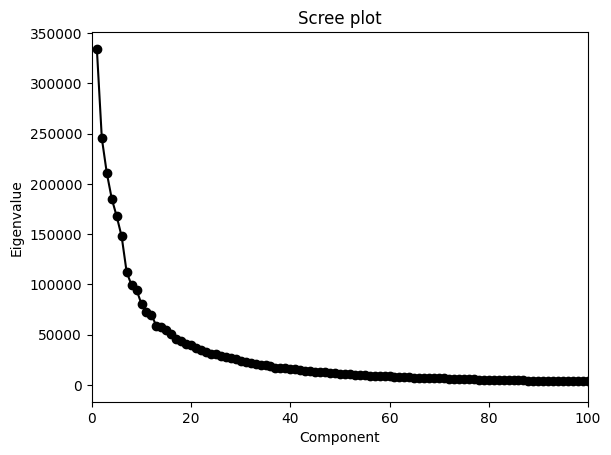

In [ ]:
# Perform PCA
score, evectors, evals = ...

# Plot the eigenvalues
plot_eigenvalues(evals, xlimit=True)  # limit x-axis up to 100 for zooming

---
## Section 7: Calculate the variance explained

*Estimated timing to here from start of tutorial: 15 min*

The scree plot suggests that most of the eigenvalues are near zero, with fewer than 100 having large values. Another common way to determine the intrinsic dimensionality is by considering the variance explained. This can be examined with a cumulative plot of the fraction of the total variance explained by the top $K$ components, i.e.,

\begin{equation}
\text{var explained} = \frac{\sum_{i=1}^K \lambda_i}{\sum_{i=1}^N \lambda_i}
\end{equation}

where $\lambda_i$ is the $i^{th}$ eigenvalue and $N$ is the total number of components (the original number of dimensions in the data).

The intrinsic dimensionality is often quantified by the $K$ necessary to explain a large proportion of the total variance of the data (often a defined threshold, e.g., 90%).

## Coding Exercise 7: Plot the explained variance

In this exercise you will plot the explained variance.

**Steps:**
- Fill in the function below to calculate the fraction variance explained as a function of the number of principal components. **Hint:** use `np.cumsum`.
- Plot the variance explained using `plot_variance_explained`.

**Questions:**
- How many principal components are required to explain 90% of the variance?
- How does the intrinsic dimensionality of this dataset compare to its extrinsic dimensionality?


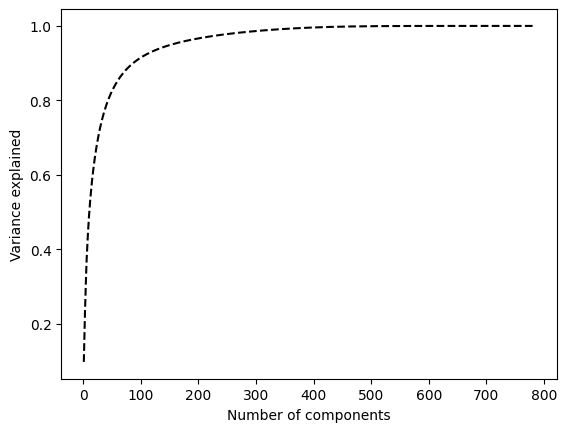

In [ ]:
def get_variance_explained(evals):
  """
  Plots eigenvalues.

  Args:
    (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  # Cumulatively sum the eigenvalues
  csum = ...

  # Normalize by the sum of eigenvalues
  variance_explained = ...

  return variance_explained


# Calculate the variance explained
variance_explained = get_variance_explained(evals)

# Visualize
plot_variance_explained(variance_explained)

---
## Section 8: Reconstruct data with different numbers of PCs


Now we have seen that the top 100 or so principal components of the data can explain most of the variance. We can use this fact to perform *dimensionality reduction*, i.e., by storing the data using only 100 components rather than the samples of all 784 pixels. Remarkably, we will be able to reconstruct much of the structure of the data using only the top 100 components. To see this, recall that to perform PCA we projected the data $\bf X$ onto the eigenvectors of the covariance matrix:

\begin{equation}
\bf S = X W
\end{equation}

Since $\bf W$ is an orthogonal matrix, ${\bf W}^{-1} = {\bf W}^\top$. So by multiplying by ${\bf W}^\top$ on each side we can rewrite this equation as  

\begin{equation}
{\bf X = S W}^\top.
\end{equation}

This now gives us a way to reconstruct the data matrix from the scores and loadings. To reconstruct the data from a low-dimensional approximation, we just have to truncate these matrices.  Let's denote ${\bf S}_{1:K}$ and ${\bf W}_{1:K}$ the matrices with only the first $K$ columns of $\bf S$ and $\bf W$, respectively. Then our reconstruction is:

\begin{equation}
{\bf \hat X = S}_{1:K} ({\bf W}_{1:K})^\top.
\end{equation}

## Coding Exercise 8: Data reconstruction

Fill in the function below to reconstruct the data using different numbers of principal components.

**Steps:**

* Fill in the following function to reconstruct the data based on the weights and scores. Don't forget to add the mean!
* Make sure your function works by reconstructing the data with all $K=784$ components. The two images should look identical.

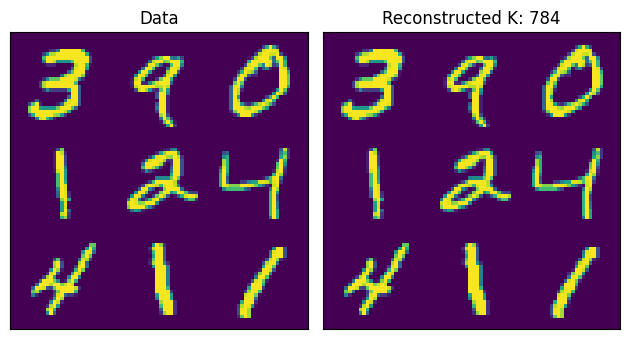

In [ ]:
# to_remove solution
def reconstruct_data(score, evectors, X_mean, K):
  """
  Reconstruct the data based on the top K components.

  Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include

  Returns:
    (numpy array of floats)          : Matrix of reconstructed data

  """

  # Reconstruct the data from the score and eigenvectors
  # Don't forget to add the mean!!
  X_reconstructed =  ...

  return X_reconstructed


K = 784  # data dimensions

# Reconstruct the data based on all components
X_mean = np.mean(X, 0)
X_reconstructed = reconstruct_data(score, evectors, X_mean, K)

# Plot the data and reconstruction
plot_MNIST_reconstruction(X, X_reconstructed, K)

## Interactive Demo 5: Reconstruct the data matrix using different numbers of PCs

Now run the code below and experiment with the slider to reconstruct the data matrix using different numbers of principal components.

1.  How many principal components are necessary to reconstruct the numbers (by eye)? How does this relate to the intrinsic dimensionality of the data?
2.  Do you see any information in the data with only a single principal component?

In [ ]:
def refresh(K=100):
  X_reconstructed = reconstruct_data(score, evectors, X_mean, K)
  plot_MNIST_reconstruction(X, X_reconstructed, K)


_ = widgets.interact(refresh, K=(1, 784, 10))

interactive(children=(IntSlider(value=100, description='K', max=784, min=1, step=10), Output()), _dom_classes=…

---
## Section 9: Visualize PCA components

## Coding Exercise 9: Visualization of the weights

Next, let's take a closer look at the first principal component by visualizing its corresponding weights.

**Steps:**

* Enter `plot_MNIST_weights` to visualize the weights of the first basis vector.
* What structure do you see? Which pixels have a strong positive weighting? Which have a strong negative weighting? What kinds of images would this basis vector differentiate (hint: think about the last demo with 1 component)?
* Try visualizing the second and third basis vectors. Do you see any structure? What about the 100th basis vector? 500th? 700th?

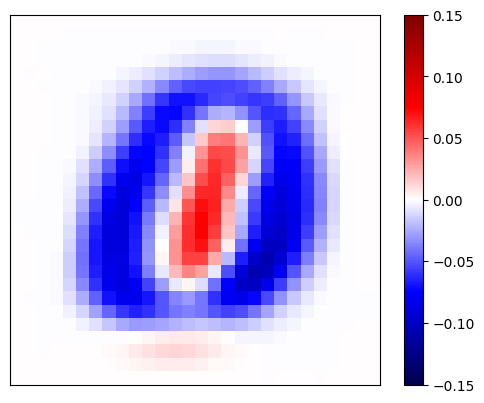

In [ ]:
plot_MNIST_weights(...)

## Bonus Section 1: Examine denoising using PCA

In this lecture, we saw that PCA finds an optimal low-dimensional basis to minimize the reconstruction error. Because of this property, PCA can be useful for denoising corrupted samples of the data.

### Bonus Coding Exercise 1: Add noise to the data
In this exercise you will add salt-and-pepper noise to the original data and see how that affects the eigenvalues.

**Steps:**
- Use the function `add_noise` to add noise to 20% of the pixels.
- Then, perform PCA and plot the variance explained. How many principal components are required to explain 90% of the variance? How does this compare to the original data?


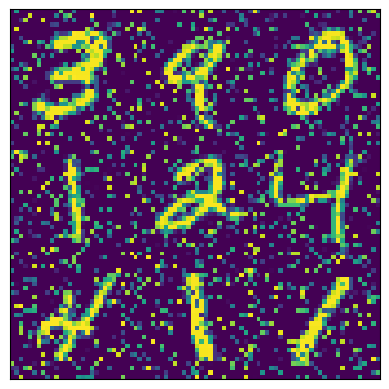

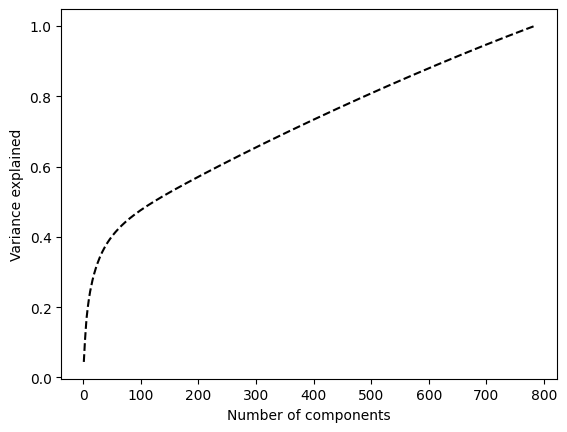

In [ ]:
np.random.seed(2020)  # set random seed

# Add noise to data
X_noisy = ...

# Perform PCA on noisy data
score_noisy, evectors_noisy, evals_noisy = ...

# Compute variance explained
variance_explained_noisy = ... # use get_variance_explained function

# Visualize

plot_MNIST_sample(X_noisy)
plot_variance_explained(variance_explained_noisy)

### Bonus Coding Exercise 2: Denoising

Next, use PCA to perform denoising by projecting the noise-corrupted data onto the basis vectors found from the original dataset. By taking the top K components of this projection, we can reduce noise in dimensions orthogonal to the K-dimensional latent space.

**Steps:**
- Subtract the mean of the noise-corrupted data.
- Project the data onto the basis found with the original dataset (`evectors`, not `evectors_noisy`) and take the top $K$ components.
- Reconstruct the data as normal, using the top 50 components.
- Play around with the amount of noise and K to build intuition.


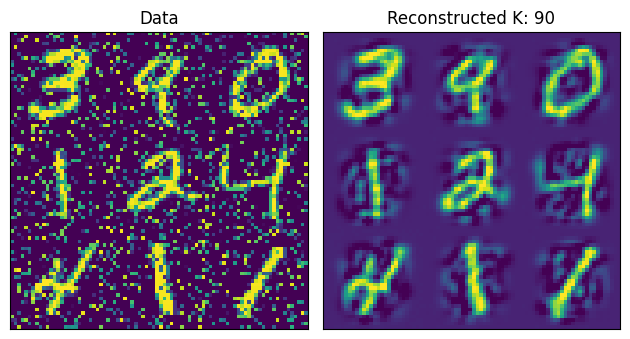

In [ ]:
np.random.seed(2020)  # set random seed

# Add noise to data
X_noisy = ...

# Compute mean of noise-corrupted data
X_noisy_mean = ...

# Project onto the original basis vectors
projX_noisy = ...

# Reconstruct the data using the top 90 components
K = 90
X_reconstructed = ... # use reconstruct_data function

# Visualize
plot_MNIST_reconstruction(X_noisy, X_reconstructed, K)

# Nonlinear Dimensionality Reduction

In [25]:
#  plotting function for later use
def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  plt.scatter(x=component1, y=component2, c=labels, cmap='tab10')
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(10))
  plt.clim(-0.5, 9.5)
  if show:
    plt.show()

---
## Section 10: Visualize MNIST in 2D using PCA

In this exercise, we'll visualize the first few components of the MNIST dataset to look for evidence of structure in the data. But in this tutorial, we will also be interested in the label of each image (i.e., which numeral it is from 0 to 9). Start by running the following cell to reload the MNIST dataset (this takes a few seconds).

In [26]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Get images
mnist = fetch_openml(name='mnist_784', as_frame=False, parser='auto')
X_all = mnist.data

# Get labels
labels_all = np.array([int(k) for k in mnist.target])

# Initializes PCA
pca_model = PCA(n_components=2)

# Performs PCA
pca_model.fit(X_all)

PCA(n_components=2)

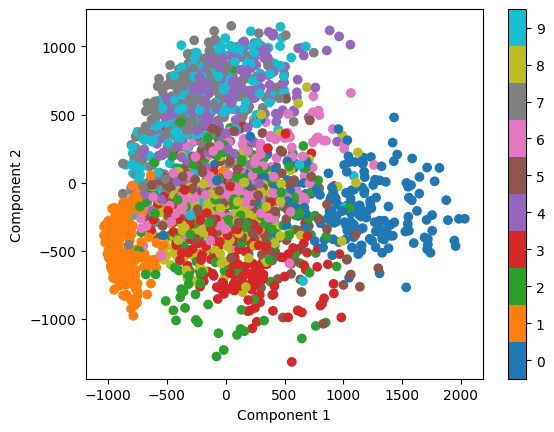

In [27]:
# Take only the first 2000 samples with the corresponding labels
X, labels = X_all[:2000, :], labels_all[:2000]

# Perform PCA
scores = pca_model.transform(X)

# Plot the data and reconstruction
visualize_components(scores[:, 0], scores[:, 1], labels)

---
## Section 11: Visualize MNIST in 2D using t-SNE



In [28]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

## Coding Exercise 11.1: Apply t-SNE on MNIST
First, we'll run t-SNE on the data to explore whether we can see more structure. The cell above defined the parameters that we will use to find our embedding (i.e, the low-dimensional representation of the data) and stored them in `model`. To run t-SNE on our data, use the function `model.fit_transform`.

**Suggestions:**
- Run t-SNE using the function `model.fit_transform`.
- Plot the result data using `visualize_components`.

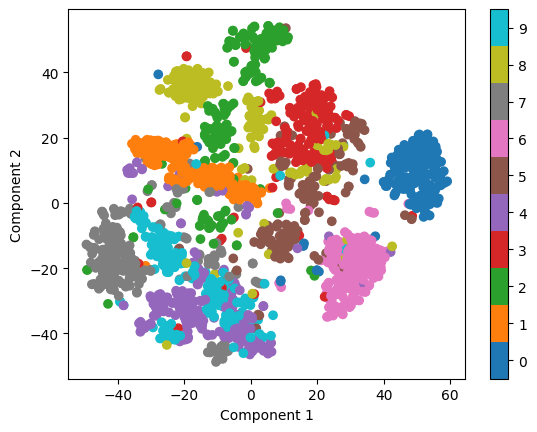

In [ ]:
# Perform t-SNE
# embed = ...
embed = tsne_model.fit_transform(X)

# Visualize the data
visualize_components(embed[:, 0], embed[:, 1], labels)

## Coding Exercise 11.2: Run t-SNE with different perplexities

Unlike PCA, t-SNE has a free parameter (the perplexity) that roughly determines how global vs. local information is weighted. Here we'll take a look at how the perplexity affects our interpretation of the results.

**Steps:**
- Rerun t-SNE (don't forget to re-initialize using the function `TSNE` as above) with a perplexity of 50, 5 and 2.

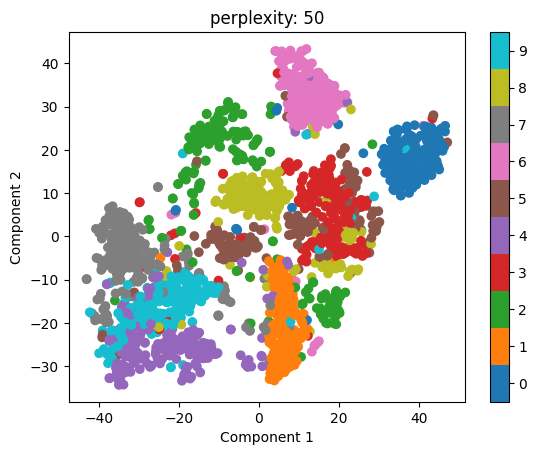

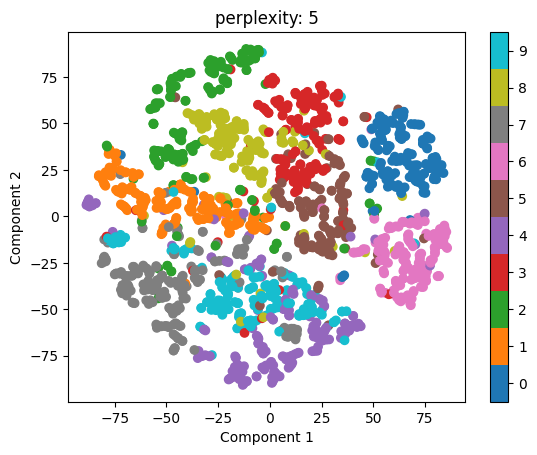

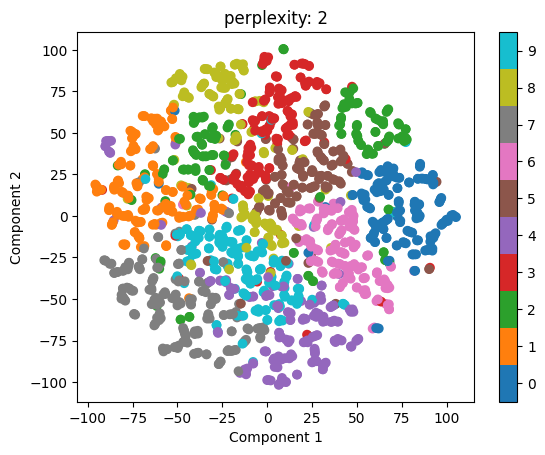

In [ ]:
def explore_perplexity(values, X, labels):
  """
  Plots a 2D representation of the data for visualization with categories
  labeled as different colors using different perplexities.

  Args:
    values (list of floats) : list with perplexities to be visualized
    X (np.ndarray of floats) : matrix with the dataset
    labels (np.ndarray of int) : array with the labels

  Returns:
    Nothing.

  """

  for perp in values:

    # Perform t-SNE
    # tsne_model = ...
    tsne_model = TSNE(n_components=2, perplexity=perp, random_state=2020)

    embed = tsne_model.fit_transform(X)
    visualize_components(embed[:, 0], embed[:, 1], labels, show=False)
    plt.title(f"perplexity: {perp}")
    plt.show()


# Visualize
values = [50, 5, 2]

explore_perplexity(values, X, labels)